In [1]:
# import some things for convenience
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
# Enum to better convey the semantics of the confidence precision (e.g., in the NINETIES as opposed to 91% or 95%)
class Confidence(Enum):
    HIGHNINETIES = 0
    NINETIES  = 1
    EIGHTIES  = 2

# create simple hist
def create_hist(x, mean, std):
    count, bins, ignored = plt.hist(x, 30, density=True)
    plt.plot(bins, 1/(std*np.sqrt(2*np.pi))*np.exp(-(bins-mean)**2/(2*std**2)), linewidth=2, color='r')
    plt.show()

def display_stats(name, x):
    print("=" * 20)
    print("Mean of {}: {}".format(name, np.mean(x)))
    print("STD of {}: {}".format(name, np.std(x)))
    print("Minimum {}: {}".format(name, np.min(x)))
    print("Maximum {}: {}".format(name, np.max(x)))
    
def find_t(confidence_fraction, sample_size):
    return st.t.ppf(1-((1-confidence_fraction)/2), sample_size - 1)

# ginarmous function that should be refactored but I'm too tired
def big_m(population, error, confidence=Confidence.NINETIES, initial_sample_size=10, max_sample_size=None, verbose=0):
    # ensure confidence is tempered for small populations
    if population.size < 80 and (confidence is Confidence.NINETIES or confidence is Confidence.HIGHNINETIES) :
        raise Exception("The confidence must be set to Confidence.EIGHTIES for populations of less than 80.")

    # init factors
    confidences = {Confidence.HIGHNINETIES:0.99, Confidence.NINETIES:0.95, Confidence.EIGHTIES:0.85}
    confidence_fraction = confidences[confidence]
    t = find_t(confidence_fraction, initial_sample_size)
    consecutive_factor = np.log10(population.size)-np.log10(initial_sample_size)
    consecutive_count = 0
    consecutive_required = np.ceil((1/(1-confidence_fraction))*consecutive_factor)

    # keep the code from running excessively
    if max_sample_size is None:
        max_sample_size = min(initial_sample_size*20, population.size/2)

    # set up initial run
    sample = np.random.choice(population, initial_sample_size)
    sample_mean = np.mean(sample)
    ci_low = sample_mean-(t*(st.sem(sample, axis=None, ddof=1)))
    ci_high = sample_mean+(t*(st.sem(sample, axis=None, ddof=1)))

    # keep going until we find "enough" consecutive results that meet our expectations
    while consecutive_count < consecutive_required and sample.size < max_sample_size:
        if sample_mean - error < ci_low and sample_mean + error > ci_high:
            consecutive_count += 1
        else:
            consecutive_count = 0
        
        sample = np.append(sample, np.random.choice(population))
        sample_mean = np.mean(sample)
        t = find_t(confidence_fraction, initial_sample_size)
        ci_low = sample_mean-(t*(st.sem(sample, axis=None, ddof=1)))
        ci_high = sample_mean+(t*(st.sem(sample, axis=None, ddof=1)))  
    
    if verbose > 1:
        create_hist(sample, sample_mean, np.std(sample))
        print("Sample mean: {}".format(sample_mean))
    
    return sample_mean, sample.size, np.std(sample)

def test_100_samples(mean, std, size, error, confidence, max_sample_size, initial_sample_size=10, verbose=1):
    # create population
    population = np.random.normal(mean, std, size)# mean and standard deviation of men's heights
    actual_mean = np.mean(population)

    if verbose > 0:
        # histogram
        create_hist(population, mean, std)
        # display population stats
        display_stats("population", population)
    
    sample_means = np.array([])
    sample_sizes = np.array([])
    sample_stds = np.array([])
    
    for x in range(100):
        sample_mean, sample_size, sample_std = big_m(population, error, confidence=confidence, max_sample_size=max_sample_size, initial_sample_size=initial_sample_size, verbose=verbose)
        sample_means = np.append(sample_means, [sample_mean])
        sample_sizes = np.append(sample_sizes, [sample_size])
        sample_stds = np.append(sample_stds, [sample_std])
    
    if verbose > 0:
        display_stats("sample_means", sample_means)
        display_stats("sample_sizes", sample_sizes)
        display_stats("sample_stds", sample_stds)
    
    results = np.nonzero((sample_means > (actual_mean-error)) & (sample_means < actual_mean+error))
    if verbose > 0:
        print("=" * 20)
        print("Total samples falling within the range specified by the error: {}".format(results[0].size))
    return sample_means, sample_sizes, sample_stds

In [3]:
# init vars
mean = 70
std = 7

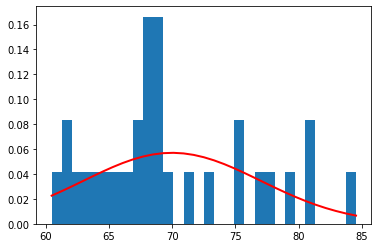

Mean of population: 69.95776082159176
STD of population: 6.21337628320553
Minimum population: 60.48175137387011
Maximum population: 84.54152056820715
Mean of sample_means: 69.97423386218915
STD of sample_means: 1.384744965306615
Minimum sample_means: 66.93089363054173
Maximum sample_means: 72.9814731318502
Mean of sample_sizes: 14.25
STD of sample_sizes: 0.4330127018922193
Minimum sample_sizes: 14.0
Maximum sample_sizes: 15.0
Mean of sample_stds: 5.933027919123289
STD of sample_stds: 1.0147830216015932
Minimum sample_stds: 3.1441828697974454
Maximum sample_stds: 8.08428597172258
Total samples falling within the range specified by the error: 100


In [4]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 30, 3.5, Confidence.EIGHTIES, None)

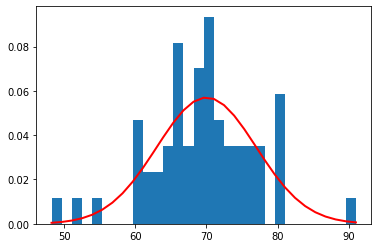

Mean of population: 69.40130643654075
STD of population: 7.282059647176254
Minimum population: 48.213845726168536
Maximum population: 91.00963878839003
Mean of sample_means: 69.44906949928483
STD of sample_means: 1.6383601854563956
Minimum sample_means: 64.7167620977374
Maximum sample_means: 73.47200276926874
Mean of sample_sizes: 18.38
STD of sample_sizes: 3.2520147601141045
Minimum sample_sizes: 16.0
Maximum sample_sizes: 30.0
Mean of sample_stds: 6.606044287972555
STD of sample_stds: 1.344483517801909
Minimum sample_stds: 3.2584185959123912
Maximum sample_stds: 9.558395889034273
Total samples falling within the range specified by the error: 97


In [5]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 60, 3.5, Confidence.EIGHTIES, None)

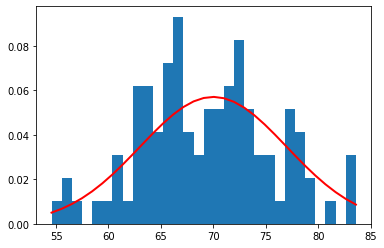

Mean of population: 69.38709349698964
STD of population: 6.217634081419911
Minimum population: 54.56891274387982
Maximum population: 83.60112983447634


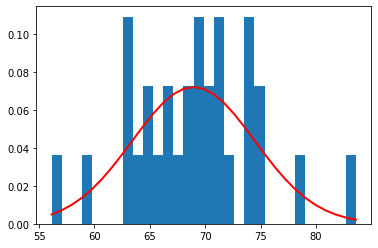

Sample mean: 68.94248222556183


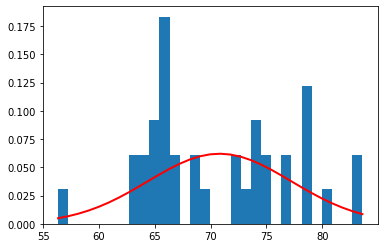

Sample mean: 70.80261932511888


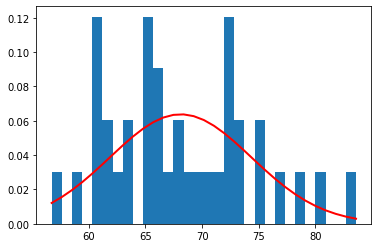

Sample mean: 68.11257769257277


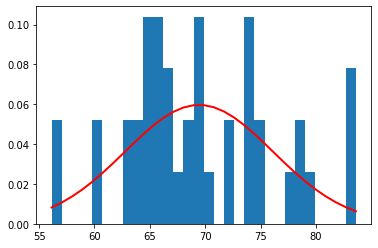

Sample mean: 69.43584948555507


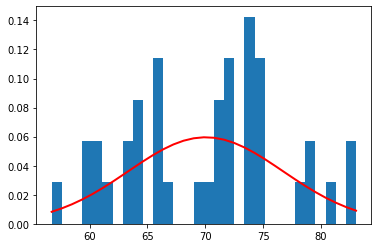

Sample mean: 70.03156424797706


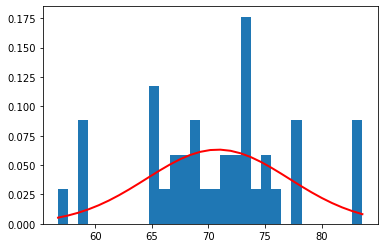

Sample mean: 70.83353442171017


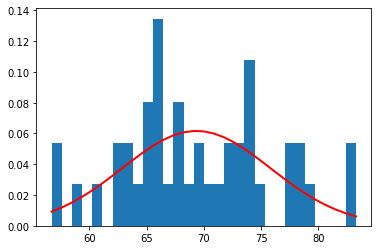

Sample mean: 69.34798435642905


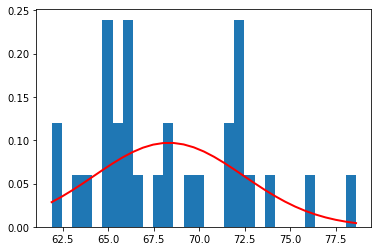

Sample mean: 68.33583456264563


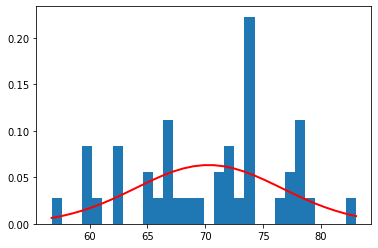

Sample mean: 70.29060092762916


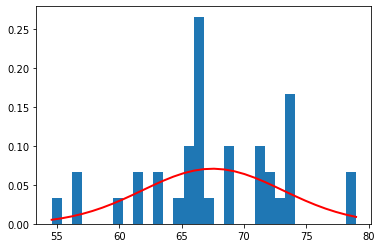

Sample mean: 67.48887202882199


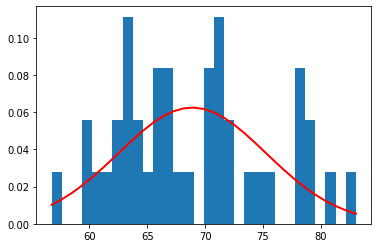

Sample mean: 68.88772966465065


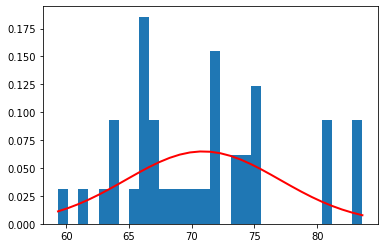

Sample mean: 70.89944804943102


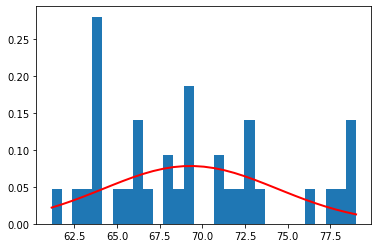

Sample mean: 69.29116474639957


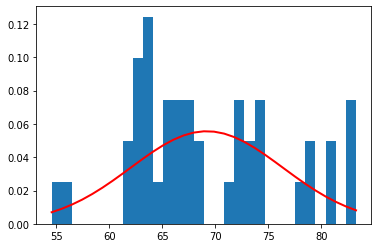

Sample mean: 69.20203919784964


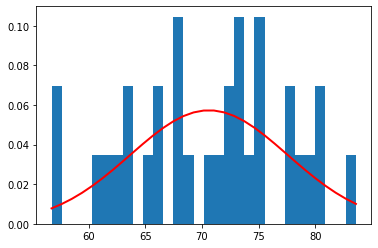

Sample mean: 70.62205051137474


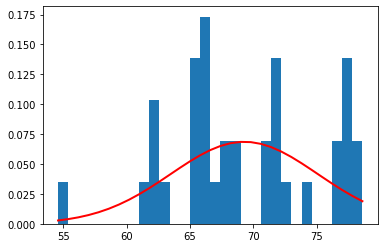

Sample mean: 69.28339499726604


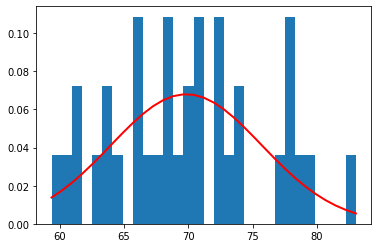

Sample mean: 69.83713906932634


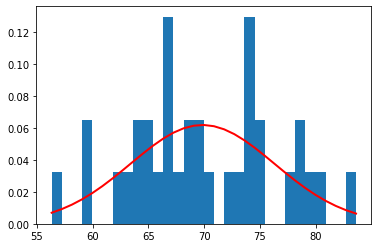

Sample mean: 69.84548859623123


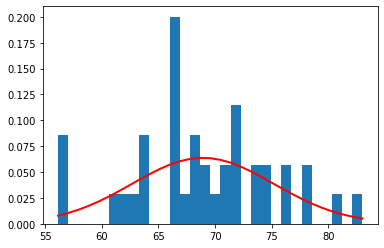

Sample mean: 68.92770420798593


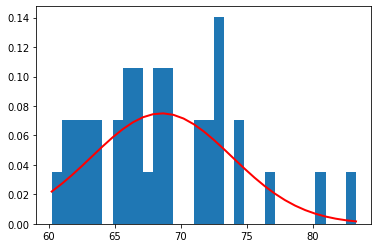

Sample mean: 68.55836902214108


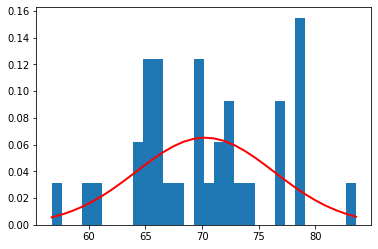

Sample mean: 70.26653256162354


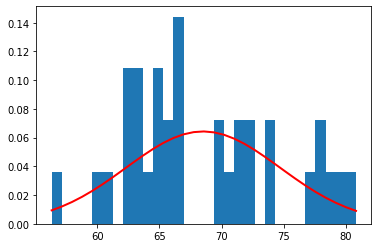

Sample mean: 68.50722857951287


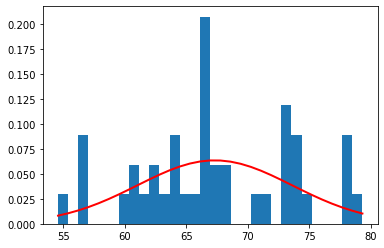

Sample mean: 67.3108144691441


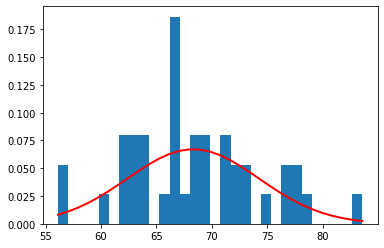

Sample mean: 68.32628120773045


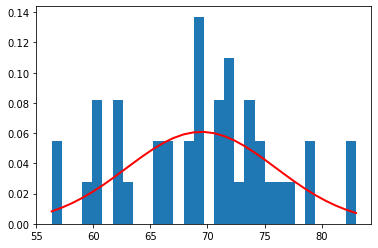

Sample mean: 69.4533707406653


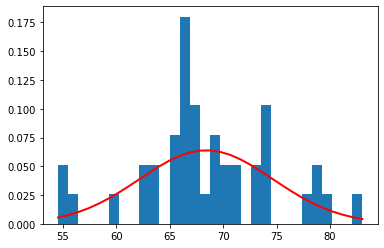

Sample mean: 68.4196270066038


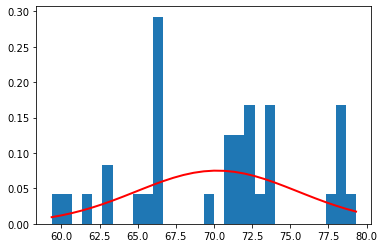

Sample mean: 70.19603470593232


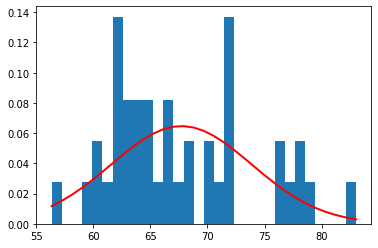

Sample mean: 67.71475990864207


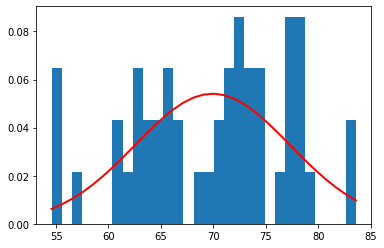

Sample mean: 69.9288831137407


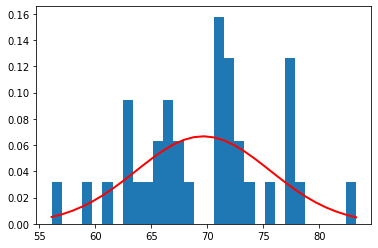

Sample mean: 69.6461453142199


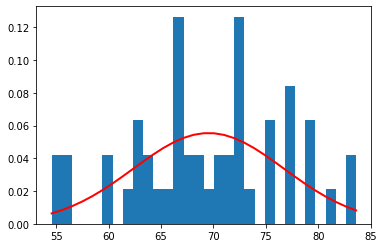

Sample mean: 69.54041623685906


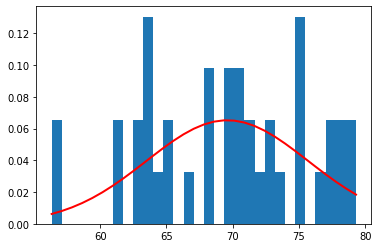

Sample mean: 69.59026832656846


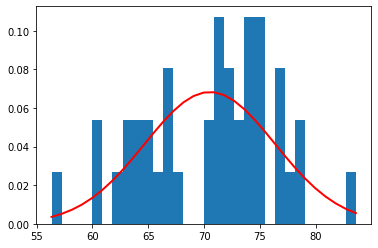

Sample mean: 70.51223532406965


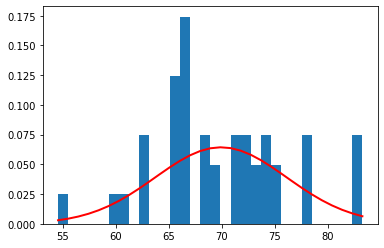

Sample mean: 69.93753164188588


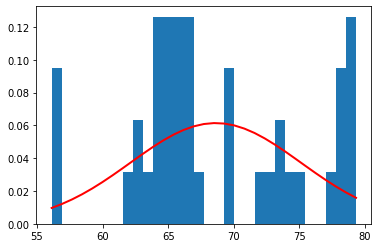

Sample mean: 68.62000509091564


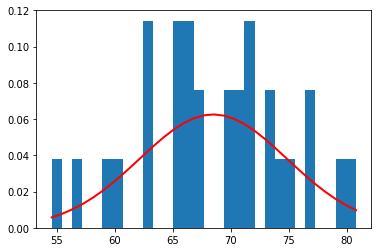

Sample mean: 68.50354297512091


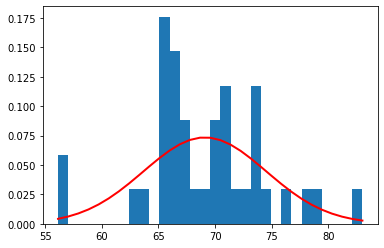

Sample mean: 69.1025739330647


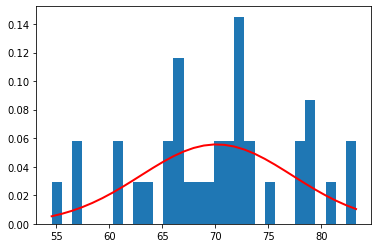

Sample mean: 70.12854132122688


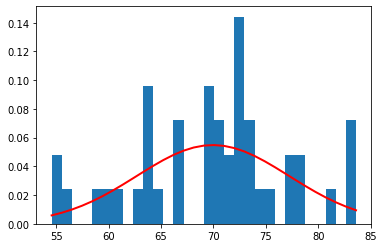

Sample mean: 69.95090099883066


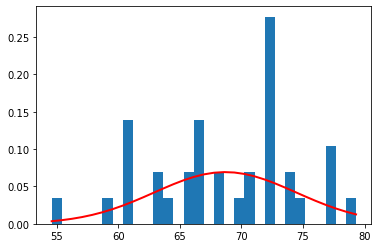

Sample mean: 68.67686858962671


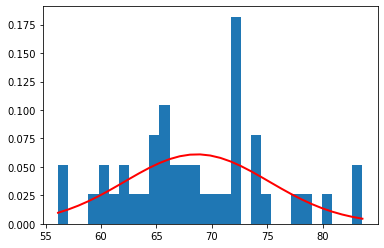

Sample mean: 68.6602315917145


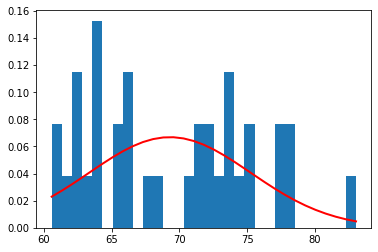

Sample mean: 69.29795813682675


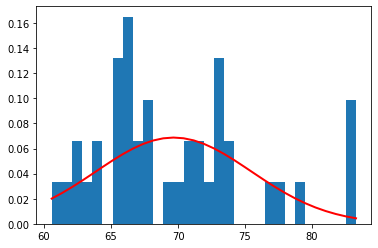

Sample mean: 69.67263942498317


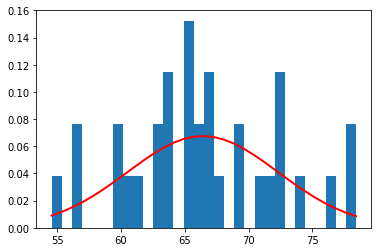

Sample mean: 66.41493926593448


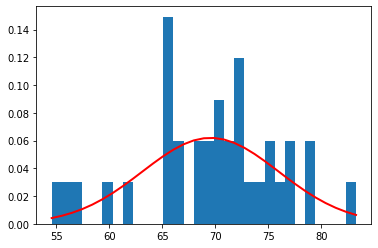

Sample mean: 69.55390275412095


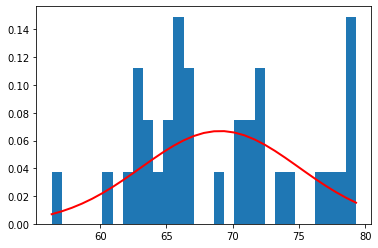

Sample mean: 69.04592661893392


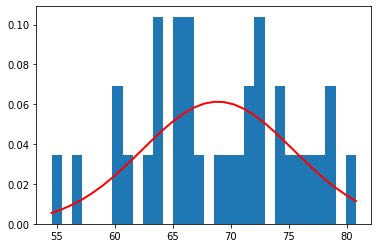

Sample mean: 68.89663503714587


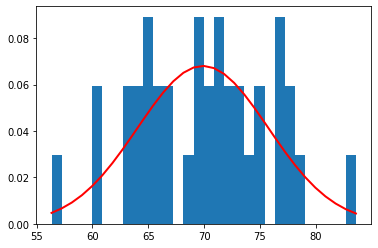

Sample mean: 69.89559518182449


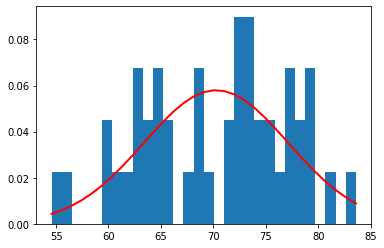

Sample mean: 70.25928220994238


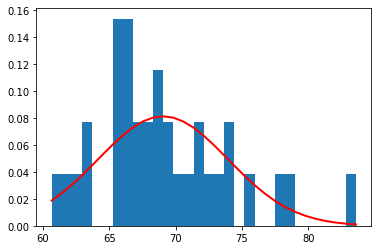

Sample mean: 69.05637702180081


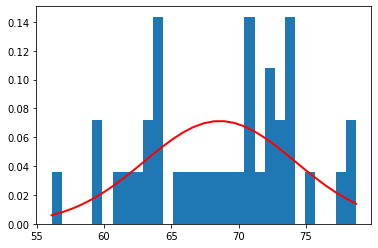

Sample mean: 68.5954221702016


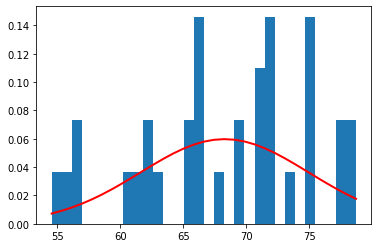

Sample mean: 68.28508203384762


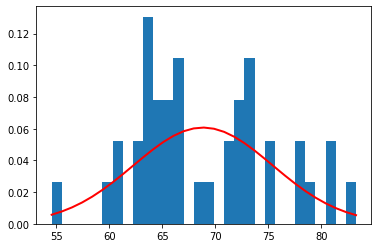

Sample mean: 68.85042242504282


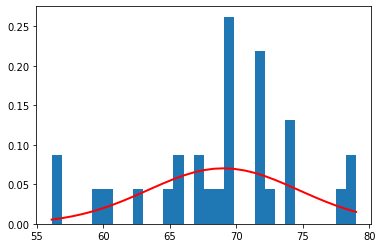

Sample mean: 69.02560024227397


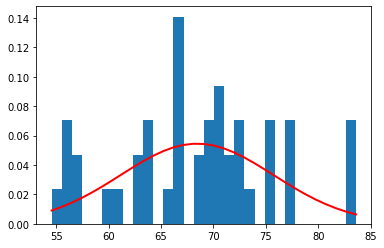

Sample mean: 68.44260167631703


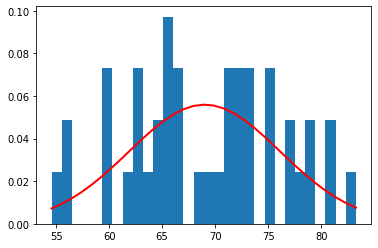

Sample mean: 69.00890699787396


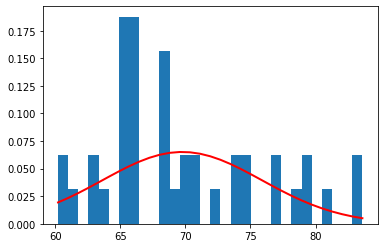

Sample mean: 69.75097079511505


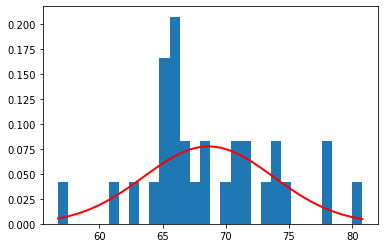

Sample mean: 68.63369300411233


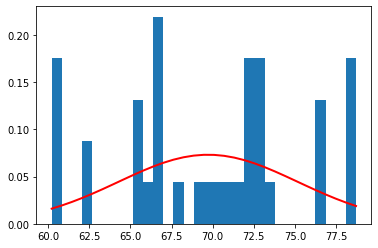

Sample mean: 69.72190020012354


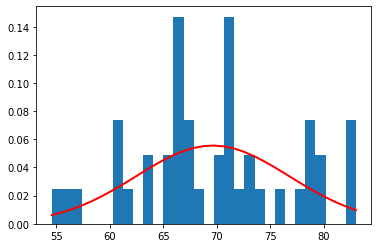

Sample mean: 69.62568471666599


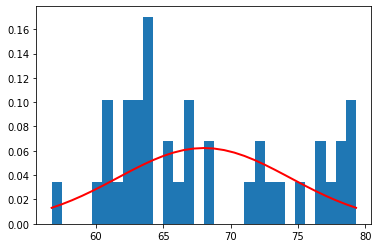

Sample mean: 68.02005699712095


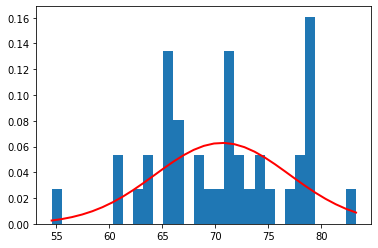

Sample mean: 70.66199704622294


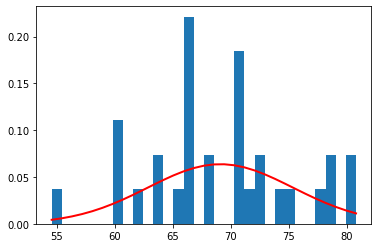

Sample mean: 69.11447997219564


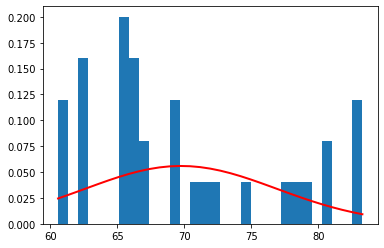

Sample mean: 69.74276817744256


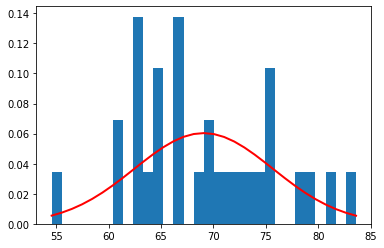

Sample mean: 69.0655489208877


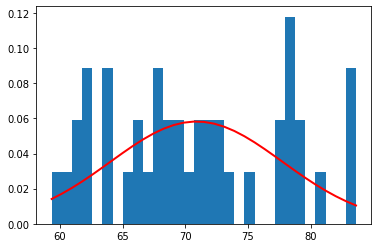

Sample mean: 70.88957803062308


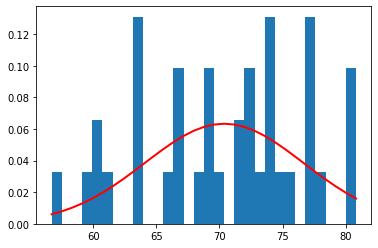

Sample mean: 70.37396529965254


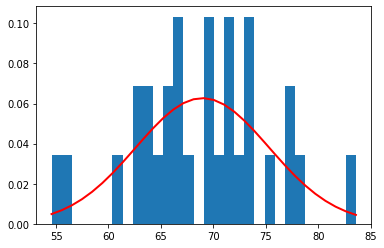

Sample mean: 68.96151368666018


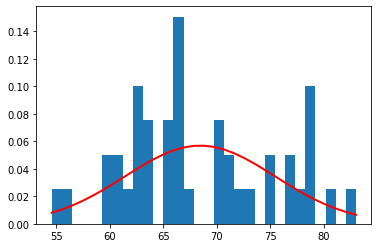

Sample mean: 68.44678170454107


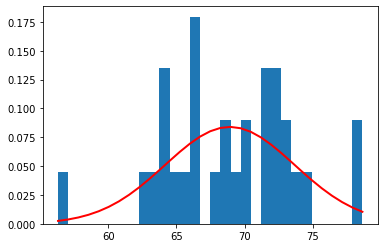

Sample mean: 68.91542792320776


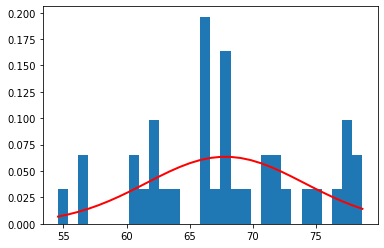

Sample mean: 67.83792058701238


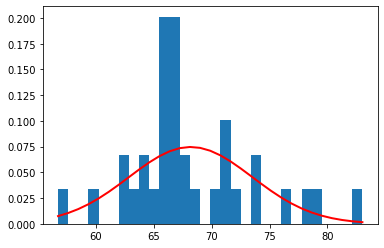

Sample mean: 68.18299322485372


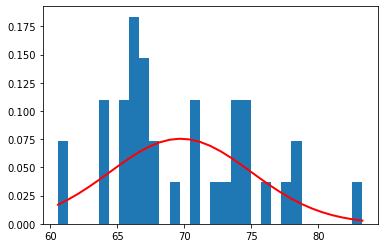

Sample mean: 69.71325885083235


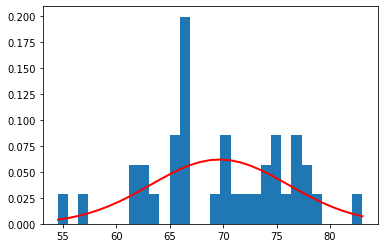

Sample mean: 69.66912911863882


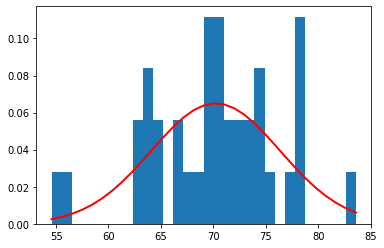

Sample mean: 70.22540282739149


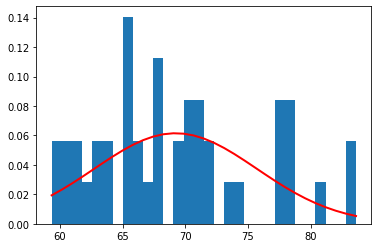

Sample mean: 69.2230547658277


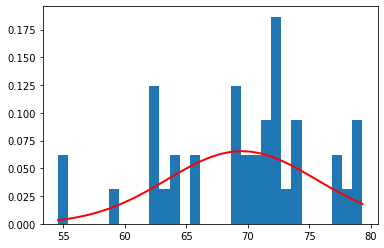

Sample mean: 69.50237245922717


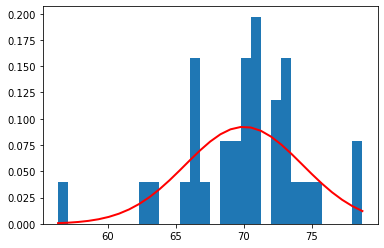

Sample mean: 70.00093956071682


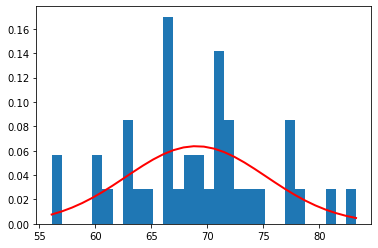

Sample mean: 69.02078102323131


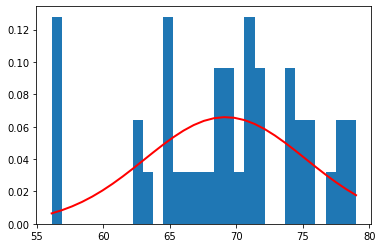

Sample mean: 69.17854958819103


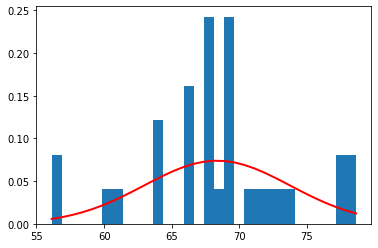

Sample mean: 68.35145102566739


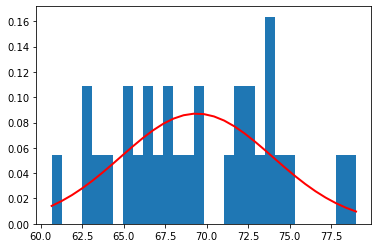

Sample mean: 69.39850640188189


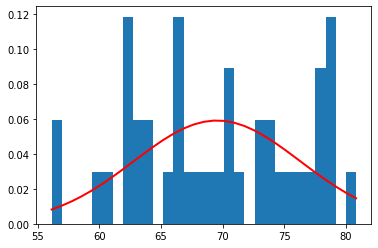

Sample mean: 69.53273855551016


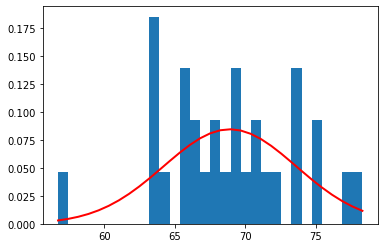

Sample mean: 68.91172385532539


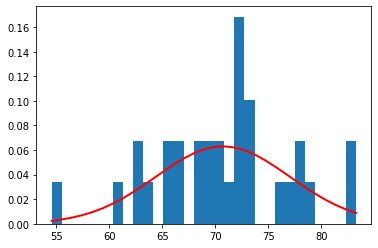

Sample mean: 70.71901006743097


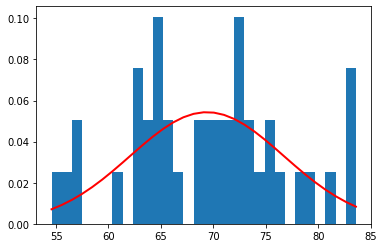

Sample mean: 69.39416743401519


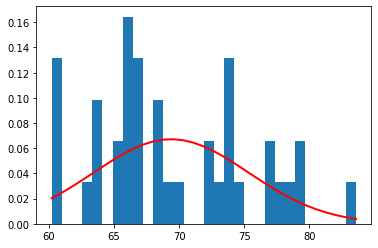

Sample mean: 69.39123037694311


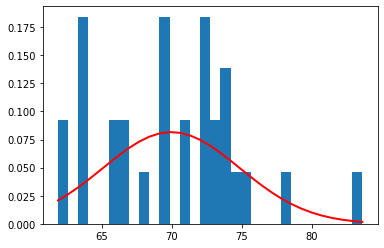

Sample mean: 69.97553120378119


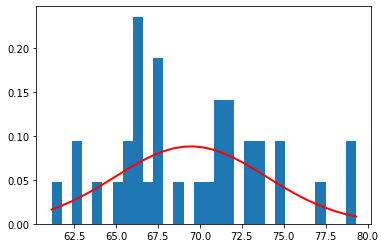

Sample mean: 69.46133173787202


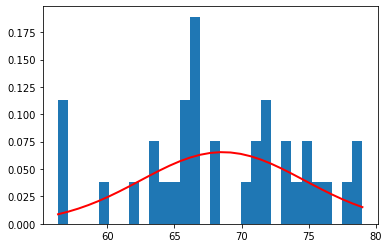

Sample mean: 68.58134866200777


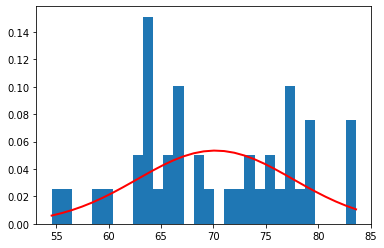

Sample mean: 70.16694826810718


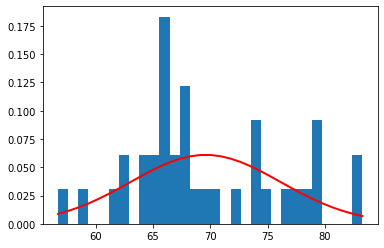

Sample mean: 69.59341551031416


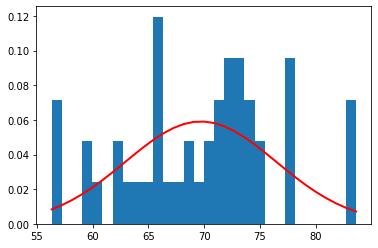

Sample mean: 69.69575213223676


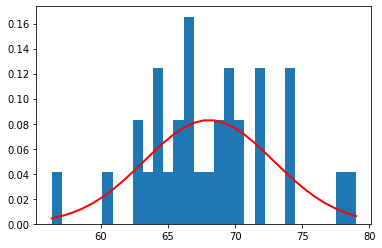

Sample mean: 68.04605542979519


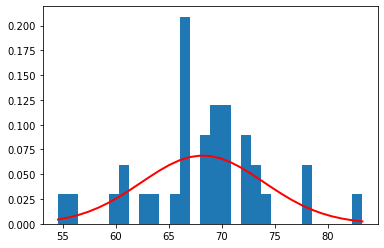

Sample mean: 68.21801084692376


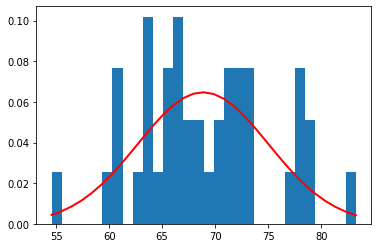

Sample mean: 68.86315231775966


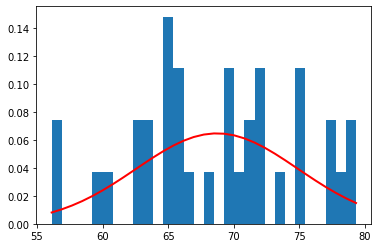

Sample mean: 68.7202006929309


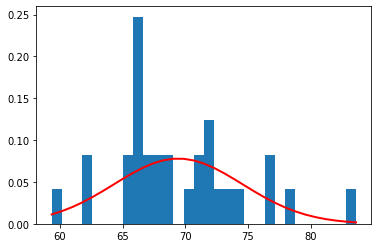

Sample mean: 69.43990578773861


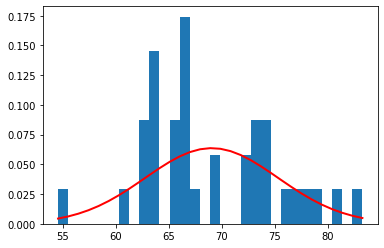

Sample mean: 69.0603375931585


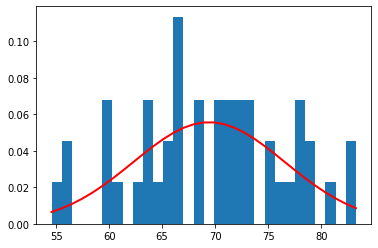

Sample mean: 69.43155556255563
Mean of sample_means: 69.25701674113895
STD of sample_means: 0.8330941706506344
Minimum sample_means: 66.41493926593448
Maximum sample_means: 70.89944804943102
Mean of sample_sizes: 37.4
STD of sample_sizes: 4.540925015897091
Minimum sample_sizes: 30.0
Maximum sample_sizes: 49.0
Mean of sample_stds: 6.132187543262022
STD of sample_stds: 0.720212042314916
Minimum sample_stds: 4.111742305933717
Maximum sample_stds: 7.461054514257854
Total samples falling within the range specified by the error: 100


In [6]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 100, 3.5, Confidence.NINETIES, None, verbose=2)

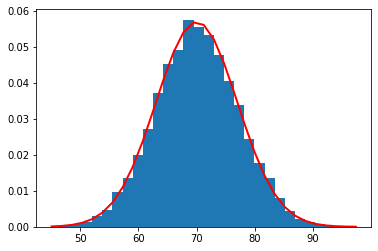

Mean of population: 70.11023326313601
STD of population: 7.086569204104949
Minimum population: 45.08742390843573
Maximum population: 97.34262526775333
Mean of sample_means: 70.16859110974177
STD of sample_means: 0.7502752318884202
Minimum sample_means: 68.06874450927269
Maximum sample_means: 72.12107777951928
Mean of sample_sizes: 81.11
STD of sample_sizes: 5.934467120138084
Minimum sample_sizes: 70.0
Maximum sample_sizes: 98.0
Mean of sample_stds: 6.984162718499022
STD of sample_stds: 0.6056789552838653
Minimum sample_stds: 5.3191501471801805
Maximum sample_stds: 8.294621242173271
Total samples falling within the range specified by the error: 100


In [7]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 10000, 3.5, Confidence.NINETIES, None)

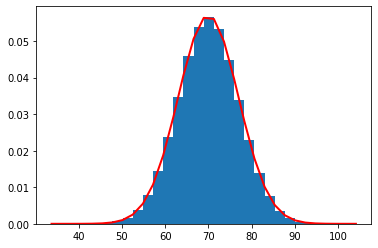

Mean of population: 70.0055964332553
STD of population: 7.008136138366746
Minimum population: 33.73182514619032
Maximum population: 104.13650283706374
Mean of sample_means: 69.97946390722201
STD of sample_means: 0.6556088234676011
Minimum sample_means: 68.4106454064506
Maximum sample_means: 71.56073882442037
Mean of sample_sizes: 120.62
STD of sample_sizes: 6.351031412298321
Minimum sample_sizes: 110.0
Maximum sample_sizes: 138.0
Mean of sample_stds: 6.9321894038775955
STD of sample_stds: 0.4591258681132831
Minimum sample_stds: 5.819470279314908
Maximum sample_stds: 8.201640866431738
Total samples falling within the range specified by the error: 100


In [8]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 3.5, Confidence.NINETIES, None)

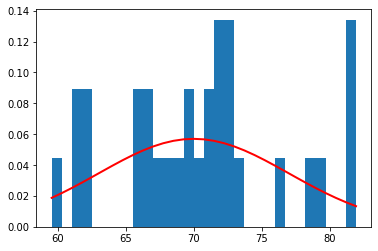

Mean of population: 70.450252026489
STD of population: 6.060752536018632
Minimum population: 59.56471555855005
Maximum population: 81.92267620431642
Mean of sample_means: 70.53993699457727
STD of sample_means: 1.8120062587576442
Minimum sample_means: 65.11690930124838
Maximum sample_means: 74.75129333179811
Mean of sample_sizes: 14.94
STD of sample_sizes: 0.23748684174075835
Minimum sample_sizes: 14.0
Maximum sample_sizes: 15.0
Mean of sample_stds: 5.678400263216402
STD of sample_stds: 0.9595349949050636
Minimum sample_stds: 2.9511486166799923
Maximum sample_stds: 8.475631817254287
Total samples falling within the range specified by the error: 77


In [9]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 30, 2, Confidence.EIGHTIES, None)

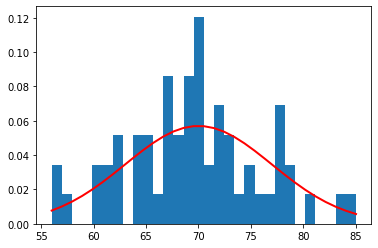

Mean of population: 69.60630155983202
STD of population: 6.264089975122434
Minimum population: 55.998354696532594
Maximum population: 85.02221803425947
Mean of sample_means: 69.7389684959852
STD of sample_means: 1.277246856201305
Minimum sample_means: 66.3300457320784
Maximum sample_means: 72.79519348636849
Mean of sample_sizes: 26.83
STD of sample_sizes: 4.249835290925991
Minimum sample_sizes: 16.0
Maximum sample_sizes: 30.0
Mean of sample_stds: 5.851121738726668
STD of sample_stds: 0.9277280923234346
Minimum sample_stds: 3.543844127784692
Maximum sample_stds: 7.934682769213758
Total samples falling within the range specified by the error: 88


In [10]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 60, 2, Confidence.EIGHTIES, None)

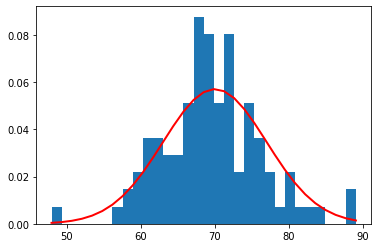

Mean of population: 69.60747481664059
STD of population: 6.6699124036205015
Minimum population: 47.95424913645765
Maximum population: 89.04542438932505
Mean of sample_means: 69.59785951779838
STD of sample_means: 1.0359773566161485
Minimum sample_means: 67.40481882205637
Maximum sample_means: 72.26210710036902
Mean of sample_sizes: 49.88
STD of sample_sizes: 0.8863407922464135
Minimum sample_sizes: 42.0
Maximum sample_sizes: 50.0
Mean of sample_stds: 6.617962375237246
STD of sample_stds: 0.8405422530166493
Minimum sample_stds: 4.593383318738042
Maximum sample_stds: 8.850860774190837
Total samples falling within the range specified by the error: 95


In [11]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 100, 2, Confidence.NINETIES, None)

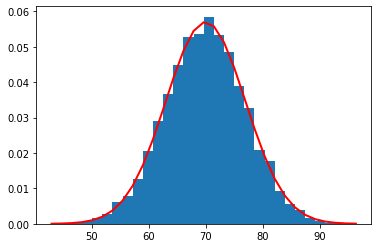

Mean of population: 69.94781823677661
STD of population: 6.979900266516932
Minimum population: 42.9707392885908
Maximum population: 96.36910327525081
Mean of sample_means: 69.88709753538616
STD of sample_means: 0.6185090067620792
Minimum sample_means: 67.87787849327617
Maximum sample_means: 71.1895099881131
Mean of sample_sizes: 122.71
STD of sample_sizes: 11.501560763652906
Minimum sample_sizes: 89.0
Maximum sample_sizes: 146.0
Mean of sample_stds: 6.868977911319132
STD of sample_stds: 0.4466638508378863
Minimum sample_stds: 5.796202715522058
Maximum sample_stds: 7.768764259619943
Total samples falling within the range specified by the error: 99


In [12]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 10000, 2, Confidence.NINETIES, None)

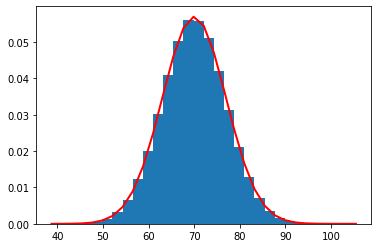

Mean of population: 69.99109050316245
STD of population: 7.003256451063896
Minimum population: 38.734286209759375
Maximum population: 105.45562658742872
Mean of sample_means: 70.05129528946352
STD of sample_means: 0.49630848377216685
Minimum sample_means: 68.98457104117422
Maximum sample_means: 71.59759585981593
Mean of sample_sizes: 163.64
STD of sample_sizes: 11.37411095426803
Minimum sample_sizes: 134.0
Maximum sample_sizes: 190.0
Mean of sample_stds: 6.964526053770956
STD of sample_stds: 0.398284549859598
Minimum sample_stds: 5.97962575223719
Maximum sample_stds: 7.882955874194754
Total samples falling within the range specified by the error: 100


In [13]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 2, Confidence.NINETIES, None)

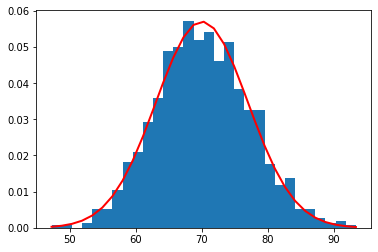

Mean of population: 70.19413185532501
STD of population: 7.064054912673699
Minimum population: 47.21156480138027
Maximum population: 93.34702498648532
Mean of sample_means: 70.24358472479635
STD of sample_means: 0.49846471774332823
Minimum sample_means: 69.06422757671479
Maximum sample_means: 71.29814418512127
Mean of sample_sizes: 200.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 200.0
Maximum sample_sizes: 200.0
Mean of sample_stds: 7.03486995090946
STD of sample_stds: 0.3446818882211274
Minimum sample_stds: 6.241801243440115
Maximum sample_stds: 7.743954578000537
Total samples falling within the range specified by the error: 94


In [14]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000, 1, Confidence.HIGHNINETIES, None)

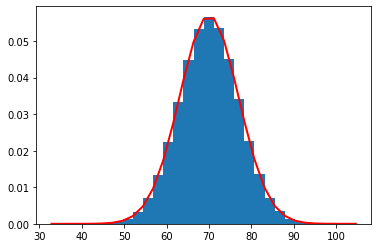

Mean of population: 70.00014891947353
STD of population: 7.00724844393153
Minimum population: 32.857962288702474
Maximum population: 104.65694335099514
Mean of sample_means: 69.94861431876102
STD of sample_means: 0.5199018245548526
Minimum sample_means: 68.65269231495482
Maximum sample_means: 71.19695285062838
Mean of sample_sizes: 200.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 200.0
Maximum sample_sizes: 200.0
Mean of sample_stds: 7.032432673412729
STD of sample_stds: 0.33948458768868667
Minimum sample_stds: 6.311308809142
Maximum sample_stds: 8.04186920439425
Total samples falling within the range specified by the error: 97


In [15]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 1, Confidence.HIGHNINETIES, None)

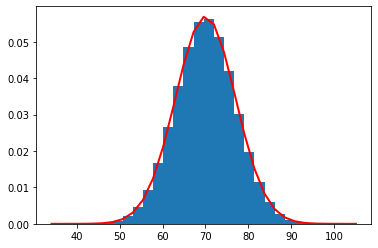

Mean of population: 69.98718226886912
STD of population: 7.003433026820628
Minimum population: 34.166113857995754
Maximum population: 105.01449874157126
Mean of sample_means: 70.00952626525488
STD of sample_means: 0.4281644828353086
Minimum sample_means: 68.68307622862353
Maximum sample_means: 70.95044264643988
Mean of sample_sizes: 300.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 300.0
Maximum sample_sizes: 300.0
Mean of sample_stds: 7.00336240051413
STD of sample_stds: 0.2933317554508309
Minimum sample_stds: 6.231282968404443
Maximum sample_stds: 7.938839747137368
Total samples falling within the range specified by the error: 99


In [16]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 1, Confidence.HIGHNINETIES, 300)